In [4]:
#!pip install prophet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from scipy.fft import fft
from statsmodels.stats.diagnostic import acorr_ljungbox

In [6]:
calendar = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/calendar.csv", parse_dates=["date"])
sales_train = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/sales_train_validation.csv")
sell_prices = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/sell_prices.csv")
sales = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/sales_train_evaluation.csv")
print(calendar.head())
print(sales_train.head())
print(sell_prices.head())
print(sales.head())
hobbies_sales = sales[sales['dept_id'] == 'HOBBIES_1'].copy()
hobbies_sales.shape

        date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0 2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1 2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2 2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3 2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4 2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIE

(4160, 1947)

In [7]:
hobbies_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [8]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [9]:
# Melt to convert from wide to long format
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
d_cols = [c for c in hobbies_sales.columns if c.startswith('d_')]
sales_melt = pd.melt(hobbies_sales, id_vars=id_cols, value_vars=d_cols, var_name='d', value_name='sales')
sales_melt

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
8074555,HOBBIES_1_420_WI_3_evaluation,HOBBIES_1_420,HOBBIES_1,HOBBIES,WI_3,WI,d_1941,0
8074556,HOBBIES_1_421_WI_3_evaluation,HOBBIES_1_421,HOBBIES_1,HOBBIES,WI_3,WI,d_1941,0
8074557,HOBBIES_1_422_WI_3_evaluation,HOBBIES_1_422,HOBBIES_1,HOBBIES,WI_3,WI,d_1941,0
8074558,HOBBIES_1_423_WI_3_evaluation,HOBBIES_1_423,HOBBIES_1,HOBBIES,WI_3,WI,d_1941,0


In [10]:
# Merge calendar
# remove 'd_' for merge
calendar['d_num'] = calendar['d'].str.replace('d_', '').astype(int)
sales_melt['d_num'] = sales_melt['d'].str.replace('d_', '').astype(int)
# remove column d, use d_num
sales_melt.drop('d', axis=1, inplace=True)
calendar.drop('d', axis=1, inplace=True)
merged = pd.merge(sales_melt, calendar, left_on='d_num', right_on='d_num', how='left')

# Merge sell_prices
merged = pd.merge(merged, sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left')

merged

,id,item_id,dept_id,cat_id,store_id,state_id,sales,d_num,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8074555,HOBBIES_1_420_WI_3_evaluation,HOBBIES_1_420,HOBBIES_1,HOBBIES,WI_3,WI,0,1941,2016-05-22,11617,...,5,2016,NaN,NaN,NaN,NaN,0,0,0,5.74
8074556,HOBBIES_1_421_WI_3_evaluation,HOBBIES_1_421,HOBBIES_1,HOBBIES,WI_3,WI,0,1941,2016-05-22,11617,...,5,2016,NaN,NaN,NaN,NaN,0,0,0,8.38
8074557,HOBBIES_1_422_WI_3_evaluation,HOBBIES_1_422,HOBBIES_1,HOBBIES,WI_3,WI,0,1941,2016-05-22,11617,...,5,2016,NaN,NaN,NaN,NaN,0,0,0,3.62
8074558,HOBBIES_1_423_WI_3_evaluation,HOBBIES_1_423,HOBBIES_1,HOBBIES,WI_3,WI,0,1941,2016-05-22,11617,...,5,2016,NaN,NaN,NaN,NaN,0,0,0,7.78


In [11]:
merged['event_type_1'].unique()

array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

# Feature Engineering

In [12]:
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values(['store_id','item_id','date'])

merged['day_of_week'] = merged['date'].dt.dayofweek  # Monday=0
merged['month'] = merged['date'].dt.month
merged['is_weekend'] = (merged['day_of_week'] >= 5).astype(int)

# flag holidays（event_type_1 not NAN then is_holiday）
merged['is_holiday'] = merged['event_type_1'].notna().astype(int)

merged.isna().sum()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
sales                 0
d_num                 0
date                  0
wm_yr_wk              0
weekday               0
wday                  0
month                 0
year                  0
event_name_1    7417280
event_type_1    7417280
event_name_2    8057920
event_type_2    8057920
snap_CA               0
snap_TX               0
snap_WI               0
sell_price      1489481
day_of_week           0
is_weekend            0
is_holiday            0
dtype: int64

18.446590278603416


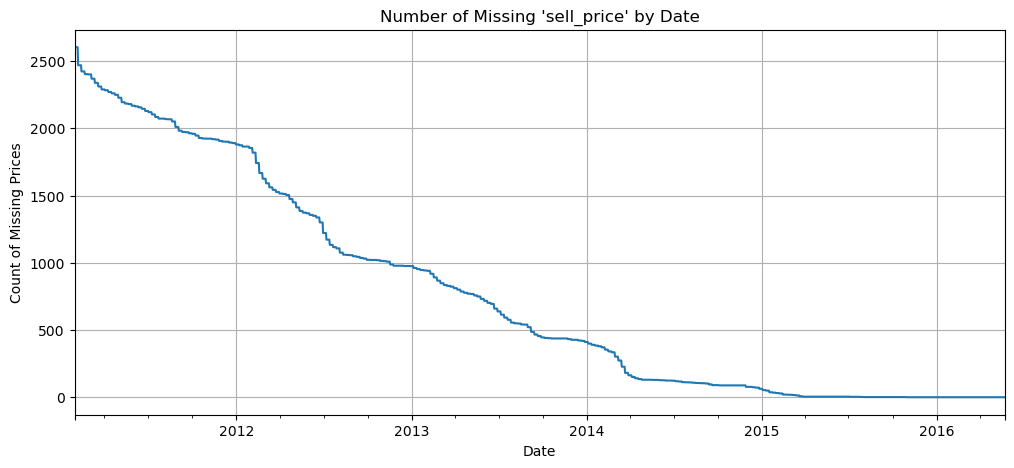

In [13]:
missing_percentage = (merged['sell_price'].isnull().sum() / len(merged)) * 100
print(missing_percentage)

daily_missing = (merged['sell_price'].isnull().groupby(merged['date']).sum())

plt.figure(figsize=(12,5))
daily_missing.plot()
plt.title("Number of Missing 'sell_price' by Date")
plt.xlabel("Date")
plt.ylabel("Count of Missing Prices")
plt.grid(True)
plt.show()

In [14]:
missing_by_id = (merged['sell_price'].isnull().groupby(merged['id']).mean()) # True=1,False=0
print(missing_by_id.sort_values(ascending=False))

id
HOBBIES_1_170_CA_4_evaluation    0.894384
HOBBIES_1_170_WI_3_evaluation    0.847501
HOBBIES_1_063_CA_4_evaluation    0.843895
HOBBIES_1_234_CA_4_evaluation    0.833076
HOBBIES_1_274_CA_4_evaluation    0.782586
                                   ...   
HOBBIES_1_317_WI_1_evaluation    0.000000
HOBBIES_1_317_TX_3_evaluation    0.000000
HOBBIES_1_317_TX_2_evaluation    0.000000
HOBBIES_1_317_TX_1_evaluation    0.000000
HOBBIES_1_343_TX_2_evaluation    0.000000
Name: sell_price, Length: 4160, dtype: float64


In [15]:
# first, use forward fill & backfill
merged = merged.sort_values(['store_id','item_id','date'])
merged['sell_price'] = merged.groupby(['store_id','item_id'])['sell_price'].ffill()
merged['sell_price'] = merged.groupby(['store_id','item_id'])['sell_price'].bfill()

# check missing percentage
missing_percentage_after_interpolation = (merged['sell_price'].isnull().sum() / len(merged)) * 100
print(f"Missing percentage after interpolation: {missing_percentage_after_interpolation:.2f}%")

Missing percentage after interpolation: 0.00%


In [16]:
merged

,id,item_id,dept_id,cat_id,store_id,state_id,sales,d_num,date,wm_yr_wk,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_of_week,is_weekend,is_holiday
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,1,2011-01-29,11101,...,NaN,NaN,NaN,0,0,0,9.58,5,1,0
4160,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2,2011-01-30,11101,...,NaN,NaN,NaN,0,0,0,9.58,6,1,0
8320,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,3,2011-01-31,11101,...,NaN,NaN,NaN,0,0,0,9.58,0,0,0
12480,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,4,2011-02-01,11101,...,NaN,NaN,NaN,1,1,0,9.58,1,0,0
16640,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,5,2011-02-02,11101,...,NaN,NaN,NaN,1,0,1,9.58,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8057919,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,0,1937,2016-05-18,11616,...,NaN,NaN,NaN,0,0,0,1.77,2,0,0
8062079,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,0,1938,2016-05-19,11616,...,NaN,NaN,NaN,0,0,0,1.77,3,0,0
8066239,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,0,1939,2016-05-20,11616,...,NaN,NaN,NaN,0,0,0,1.77,4,0,0
8070399,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,1,1940,2016-05-21,11617,...,NaN,NaN,NaN,0,0,0,1.77,5,1,0


In [17]:
"""
# item_id mean price to fillna
item_mean_prices = merged.groupby('item_id')['sell_price'].mean().rename('item_price_mean')
merged = pd.merge(merged, item_mean_prices, how='left', on='item_id')
merged['sell_price_filled'] = merged['sell_price'].fillna(merged['item_price_mean'])

# check missing percentage
missing_percentage_after_interpolation = (merged['sell_price_filled'].isnull().sum() / len(merged)) * 100
print(f"Missing percentage after interpolation: {missing_percentage_after_interpolation:.2f}%")
"""

'\n# item_id mean price to fillna\nitem_mean_prices = merged.groupby(\'item_id\')[\'sell_price\'].mean().rename(\'item_price_mean\')\nmerged = pd.merge(merged, item_mean_prices, how=\'left\', on=\'item_id\')\nmerged[\'sell_price_filled\'] = merged[\'sell_price\'].fillna(merged[\'item_price_mean\'])\n\n# check missing percentage\nmissing_percentage_after_interpolation = (merged[\'sell_price_filled\'].isnull().sum() / len(merged)) * 100\nprint(f"Missing percentage after interpolation: {missing_percentage_after_interpolation:.2f}%")\n'

In [18]:
# lag/rolling (store_id+item_id)
grp = merged.groupby(['store_id','item_id'])['sales']
# Sales volume of the same store and the same product one week ago (7 days ago)
merged['sales_lag7'] = grp.shift(7)
merged['sales_lag28'] = grp.shift(28)
# average sales volume of the previous week
merged['sales_roll7'] = grp.shift(7).rolling(7).mean()
merged['sales_roll28'] = grp.shift(28).rolling(28).mean()

# missing value（The lag column for sales will have NaN, impute with 0 since it doesn't have a big impact on the whole）
for c in ['sales_lag7','sales_lag28','sales_roll7','sales_roll28']:
    merged[c] = merged[c].fillna(0)

# price change percent
merged['sell_price_lag1'] = merged.groupby(['store_id','item_id'])['sell_price'].shift(1)
merged['price_change'] = (merged['sell_price'] - merged['sell_price_lag1']) / merged['sell_price_lag1']
# missing value - if there is no previous day's price or if the price is unchanged, treated as unchanged
merged['price_change'].fillna(0, inplace=True)

C:\Users\wxiny\AppData\Local\Temp\ipykernel_28020\2204435789.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['price_change'].fillna(0, inplace=True)


In [19]:
merged

,id,item_id,dept_id,cat_id,store_id,state_id,sales,d_num,date,wm_yr_wk,...,sell_price,day_of_week,is_weekend,is_holiday,sales_lag7,sales_lag28,sales_roll7,sales_roll28,sell_price_lag1,price_change
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,1,2011-01-29,11101,...,9.58,5,1,0,0.0,0.0,0.000000,0.000000,NaN,0.0
4160,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2,2011-01-30,11101,...,9.58,6,1,0,0.0,0.0,0.000000,0.000000,9.58,0.0
8320,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,3,2011-01-31,11101,...,9.58,0,0,0,0.0,0.0,0.000000,0.000000,9.58,0.0
12480,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,4,2011-02-01,11101,...,9.58,1,0,0,0.0,0.0,0.000000,0.000000,9.58,0.0
16640,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,5,2011-02-02,11101,...,9.58,2,0,0,0.0,0.0,0.000000,0.000000,9.58,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8057919,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,0,1937,2016-05-18,11616,...,1.77,2,0,0,0.0,0.0,0.142857,0.178571,1.77,0.0
8062079,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,0,1938,2016-05-19,11616,...,1.77,3,0,0,0.0,0.0,0.000000,0.178571,1.77,0.0
8066239,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,0,1939,2016-05-20,11616,...,1.77,4,0,0,0.0,2.0,0.000000,0.250000,1.77,0.0
8070399,HOBBIES_1_424_WI_3_evaluation,HOBBIES_1_424,HOBBIES_1,HOBBIES,WI_3,WI,1,1940,2016-05-21,11617,...,1.77,5,1,0,0.0,3.0,0.000000,0.357143,1.77,0.0


In [20]:
# Aggregation to departmental level
# 1 row per date, aggregating total departmental sales and constructing exogenous variables
agg_dict = {
        'sales': 'sum',
        'sell_price': 'mean',
        'price_change': 'mean',
        'is_holiday': 'max',
        'is_weekend': 'max',
    }
agg_dict['day_of_week'] = 'mean'
agg_dict['month'] = 'mean'

dept_df = merged.groupby('date').agg(agg_dict).reset_index().sort_values('date')

dept_df['day_of_week'] = dept_df['day_of_week'].astype(int)
dept_df['month'] = dept_df['month'].astype(int)

dept_df.set_index('date', inplace=True)

In [21]:
dept_df

,sales,sell_price,price_change,is_holiday,is_weekend,day_of_week,month
date,,,,,,,
2011-01-29,3610,6.516250,0.000000,0,1,5,1
2011-01-30,3172,6.516250,0.000000,0,1,6,1
2011-01-31,2497,6.516250,0.000000,0,0,0,1
2011-02-01,2531,6.516250,0.000000,0,0,1,2
2011-02-02,1714,6.516250,0.000000,0,0,2,2
...,...,...,...,...,...,...,...
2016-05-18,3291,6.601663,0.000000,0,0,2,5
2016-05-19,3027,6.601663,0.000000,0,0,3,5
2016-05-20,3761,6.601663,0.000000,0,0,4,5


# Model Preparation

In [22]:
cutoff='2016-04-24'

cutoff_date = pd.to_datetime(cutoff)
train = dept_df[dept_df.index <= cutoff_date]
test = dept_df[dept_df.index > cutoff_date]

print("Train range: {} ~ {}, shape={}".format(train.index.min(), train.index.max(), train.shape))
print("Test range:  {} ~ {}, shape={}".format(test.index.min(), test.index.max(), test.shape))

Train range: 2011-01-29 00:00:00 ~ 2016-04-24 00:00:00, shape=(1913, 7)
Test range:  2016-04-25 00:00:00 ~ 2016-05-22 00:00:00, shape=(28, 7)


# EDA

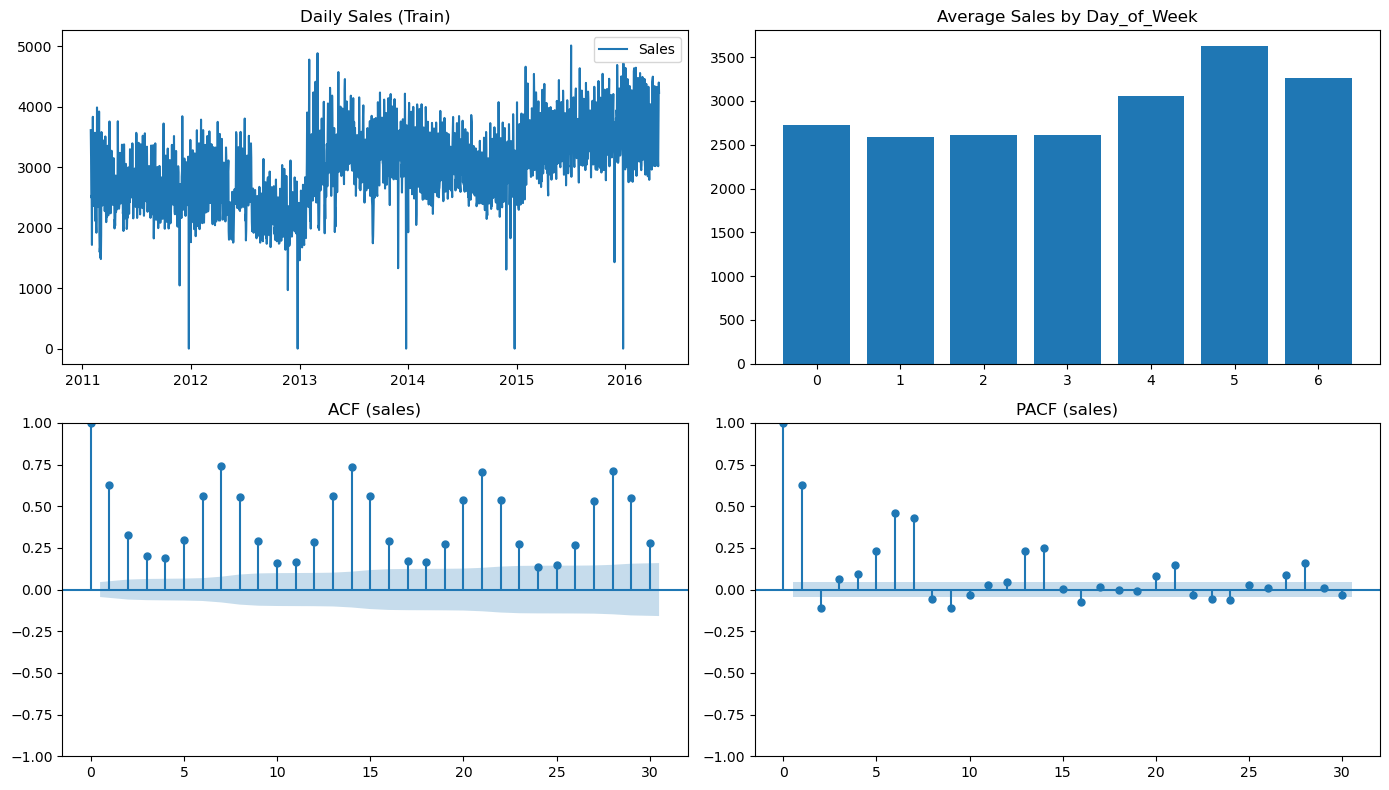

In [23]:
fig, axes = plt.subplots(2,2, figsize=(14,8))
axes = axes.flatten()

# time series plot
axes[0].plot(train.index, train['sales'], label='Sales')
axes[0].set_title('Daily Sales (Train)')
axes[0].legend()

# day_of_week: 0=Monday,...,6=Sunday
weekday_pattern = train.groupby('day_of_week')['sales'].mean()
axes[1].bar(weekday_pattern.index, weekday_pattern.values)
axes[1].set_title('Average Sales by Day_of_Week')
axes[1].set_xticks([0,1,2,3,4,5,6])

# ACF
plot_acf(train['sales'], ax=axes[2], lags=30, title='ACF (sales)')
# PACF
plot_pacf(train['sales'], ax=axes[3], lags=30, title='PACF (sales)')

plt.tight_layout()
plt.show()

C:\Users\wxiny\AppData\Local\Temp\ipykernel_28020\1224739004.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  sample_data = train['sales'].last('90D')


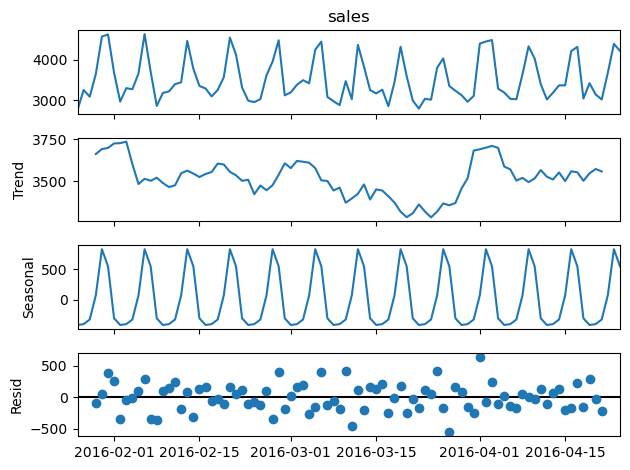

In [24]:
sample_data = train['sales'].last('90D')
result = seasonal_decompose(sample_data, model='additive', period=7)
result.plot()
plt.show()

In [25]:
"""
# Plot time series data
plt.figure(figsize=(15, 6))
plt.plot(daily_sales)
plt.title('Hobbies Category Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
#plt.savefig(f"{title.replace(' ', '_')}.png")
"""

'\n# Plot time series data\nplt.figure(figsize=(15, 6))\nplt.plot(daily_sales)\nplt.title(\'Hobbies Category Daily Sales\')\nplt.xlabel(\'Date\')\nplt.ylabel(\'Sales\')\nplt.grid(True)\n#plt.savefig(f"{title.replace(\' \', \'_\')}.png")\n'

In [26]:
"""
# Perform seasonal decomposition
# Resample to weekly data to make decomposition more visible
weekly_data = daily_sales.resample('W').sum()
    
# Perform decomposition
decomposition = seasonal_decompose(weekly_data, model='multiplicative', period=52)
    
# Plot components
plt.figure(figsize=(15, 10))
    
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.grid(True)
    
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.grid(True)
    
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')
plt.grid(True)
    
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residuals')
plt.grid(True)
    
plt.tight_layout()
"""

"\n# Perform seasonal decomposition\n# Resample to weekly data to make decomposition more visible\nweekly_data = daily_sales.resample('W').sum()\n    \n# Perform decomposition\ndecomposition = seasonal_decompose(weekly_data, model='multiplicative', period=52)\n    \n# Plot components\nplt.figure(figsize=(15, 10))\n    \nplt.subplot(411)\nplt.plot(decomposition.observed)\nplt.title('Observed')\nplt.grid(True)\n    \nplt.subplot(412)\nplt.plot(decomposition.trend)\nplt.title('Trend')\nplt.grid(True)\n    \nplt.subplot(413)\nplt.plot(decomposition.seasonal)\nplt.title('Seasonality')\nplt.grid(True)\n    \nplt.subplot(414)\nplt.plot(decomposition.resid)\nplt.title('Residuals')\nplt.grid(True)\n    \nplt.tight_layout()\n"

# Modeling

In [27]:
def detect_seasonality(series, max_period=30):
    # Use FFT to detect potential periods
    n = len(series)
    freq = np.fft.fftfreq(n)
    fft_vals = np.abs(fft(series.fillna(0)))
    
    # Exclude zero and negative frequencies
    idx = np.where((freq > 0) & (freq < 0.5))[0]
    periods = (1 / freq[idx]).astype(int)
    strengths = fft_vals[idx]
    
    # appropriate range of periods
    mask = (periods >= 2) & (periods <= max_period)
    return pd.DataFrame({
        'period': periods[mask],
        'strength': strengths[mask]
    }).sort_values('strength', ascending=False)

seasonality_df = detect_seasonality(train['sales'])
print("Top Potential Periods：\n", seasonality_df.head(5))

Top Potential Periods：
      period       strength
211       7  420585.370202
212       6  140507.286184
484       3  116815.599195
485       3  113683.869969
210       7   66907.300996


In [37]:
best_period = seasonality_df.iloc[0]['period']
best_period = int(best_period)

def model_ets(train, test):
    # only use ETS (Holt-Winters)
    print('best_period: ', best_period)
    
    ets_model = ExponentialSmoothing(
        train['sales'],
        trend='add',
        seasonal='add',
        seasonal_periods=best_period,
        damped_trend=True
    ).fit(optimized=True)

    residuals = ets_model.resid

    # Residual Autocorrelation (Ljung-Box test)
    lb_test = acorr_ljungbox(residuals, lags=[1,2,3,4,5,6,7,8,9,10, 15, 20], return_df=True)
    print(lb_test)

    # ACF/PACF plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plot_acf(residuals, lags=30, ax=plt.gca())
    plt.title("ACF of ETS Residuals")

    plt.subplot(1, 2, 2)
    plot_pacf(residuals, lags=30, ax=plt.gca())
    plt.title("PACF of ETS Residuals")

    plt.tight_layout()
    plt.show()
    
    fh = len(test)
    forecast_ets = ets_model.forecast(fh)
    return ets_model, forecast_ets

def model_ets_arima_hybrid(train, test):
    # First fit an ETS model, Next fit ARIMA model to the residuals from the ETS model
    # overall forecast = ets_forecast + arima_forecast
    # ETS
    ets_model = ExponentialSmoothing(
        train['sales'],
        trend='add',
        seasonal='add',
        seasonal_periods=best_period,
        damped_trend=True
    ).fit(optimized=True)

    residuals = ets_model.resid
    
    # Fit ARIMA model to the residuals
    arima_res = auto_arima(
        residuals,
        seasonal=True,
        m=best_period,
        trace=False,
        error_action='ignore',
        suppress_warnings=True
    )
    print("ARIMA residual model order:", arima_res.order, "seasonal_order:", arima_res.seasonal_order)

    fh = len(test)
    ets_forecast = ets_model.forecast(fh)

    # pmdarima
    arima_forecast = arima_res.predict(n_periods=fh)

    hybrid_forecast = ets_forecast + arima_forecast

    # Residual Autocorrelation (Ljung-Box test)
    lb_test = acorr_ljungbox(residuals, lags=[1,2,3,4,5,6,7,8,9,10, 14, 20,28,29,30,60,90], return_df=True)
    print(lb_test)
    
    return ets_model, arima_res, hybrid_forecast,lb_test

In [39]:
# print("\n ETS")
# ets_model, forecast_ets = model_ets(train, test)

print("\n ETS + ARIMA (Hybrid)")
ets_model2, arima_model_res, forecast_hybrid,lb_test = model_ets_arima_hybrid(train, test)


 ETS + ARIMA (Hybrid)


d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA residual model order: (1, 0, 0) seasonal_order: (0, 0, 0, 7)
       lb_stat     lb_pvalue
1    32.032314  1.516293e-08
2    32.740271  7.772136e-08
3    32.881971  3.410685e-07
4    34.585110  5.652143e-07
5    43.255883  3.279059e-08
6    59.123573  6.780650e-11
7    60.780480  1.054220e-10
8    72.296355  1.712644e-12
9    76.228263  9.037305e-13
10   83.238534  1.160574e-13
14   87.582020  1.084078e-12
20   94.472160  1.212337e-11
28  116.665252  8.628506e-13
29  124.490831  8.471745e-14
30  132.583267  7.427300e-15
60  177.988005  1.268364e-13
90  217.620006  1.425473e-12


In [30]:
def evaluate_forecast(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [31]:
result_df = pd.DataFrame({
        'Actual': test['sales'],
        'ETS': forecast_ets,
        'ETS+ARIMA': forecast_hybrid
    }, index=test.index)

models = ['ETS','ETS+ARIMA']
eval_dict = {}
for m in models:
    metrics = evaluate_forecast(result_df['Actual'], result_df[m])
    eval_dict[m] = metrics

eval_df = pd.DataFrame(eval_dict).T
print("\n Evaluation Metrics")
print(eval_df)


 Evaluation Metrics
                 RMSE         MAE      MAPE
ETS        266.176010  188.770913  4.877476
ETS+ARIMA  265.906239  187.892662  4.851386


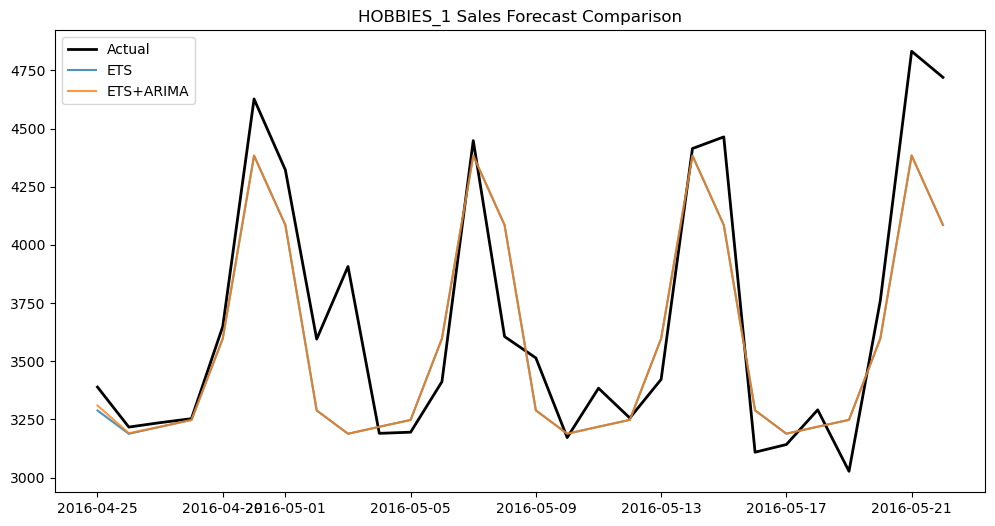

In [32]:
plt.figure(figsize=(12,6))
plt.plot(result_df.index, result_df['Actual'], label='Actual', linewidth=2, color='black')
for m in models:
    plt.plot(result_df.index, result_df[m], label=m, alpha=0.8)
plt.title('HOBBIES_1 Sales Forecast Comparison')
plt.legend()
plt.show()

In [33]:
# Choose the best model based on evaluation metrics
best_model = eval_df['RMSE'].idxmin()  # Using RMSE as criterion
print(f"Best model based on RMSE: {best_model}")

# df with only date and sales forecast
final_forecast = pd.DataFrame({
    'date': result_df.index,
    'sales': result_df[best_model]
}).reset_index(drop=True)

final_forecast = final_forecast.head(28)

print("\nFinal Forecast (28 days):")
print(final_forecast)

Best model based on RMSE: ETS+ARIMA

Final Forecast (28 days):
         date        sales
0  2016-04-25  3309.737154
1  2016-04-26  3190.814435
2  2016-04-27  3218.414133
3  2016-04-28  3247.597115
4  2016-04-29  3597.079535
5  2016-04-30  4383.546768
6  2016-05-01  4085.147331
7  2016-05-02  3288.494175
8  2016-05-03  3188.206637
9  2016-05-04  3218.216956
10 2016-05-05  3247.710479
11 2016-05-06  3597.231622
12 2016-05-07  4383.702410
13 2016-05-08  4085.301991
14 2016-05-09  3288.647282
15 2016-05-10  3188.358131
16 2016-05-11  3218.366845
17 2016-05-12  3247.858779
18 2016-05-13  3597.378349
19 2016-05-14  4383.847582
20 2016-05-15  4085.445623
21 2016-05-16  3288.789391
22 2016-05-17  3188.498733
23 2016-05-18  3218.505956
24 2016-05-19  3247.996415
25 2016-05-20  3597.514526
26 2016-05-21  4383.982314
27 2016-05-22  4085.578927
